In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
PATH = '/kaggle/input/utkface-new/UTKFace'

In [3]:
image_paths = []
age_labels = []

for filename in os.listdir(PATH):
    image_path = os.path.join(PATH, filename)
    age = int(filename.split('_')[0])
    image_paths.append(image_path)
    age_labels.append(age)

In [4]:
X = np.array(image_paths)
y = np.array(age_labels)

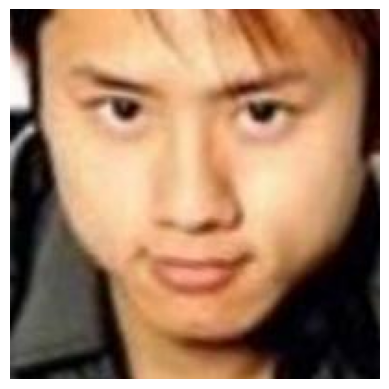

In [5]:
img = Image.open(image_paths[0])
plt.axis('off')
plt.imshow(img)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

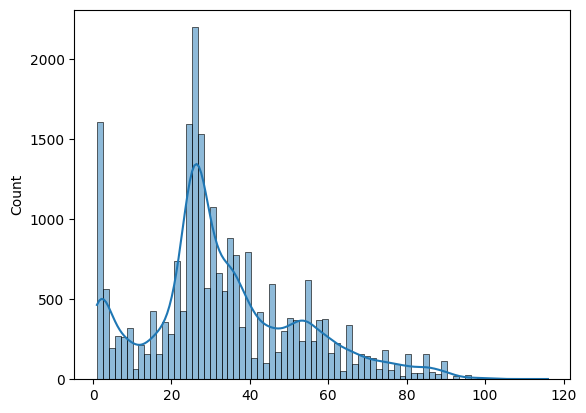

In [6]:
sns.histplot(age_labels, kde=True)

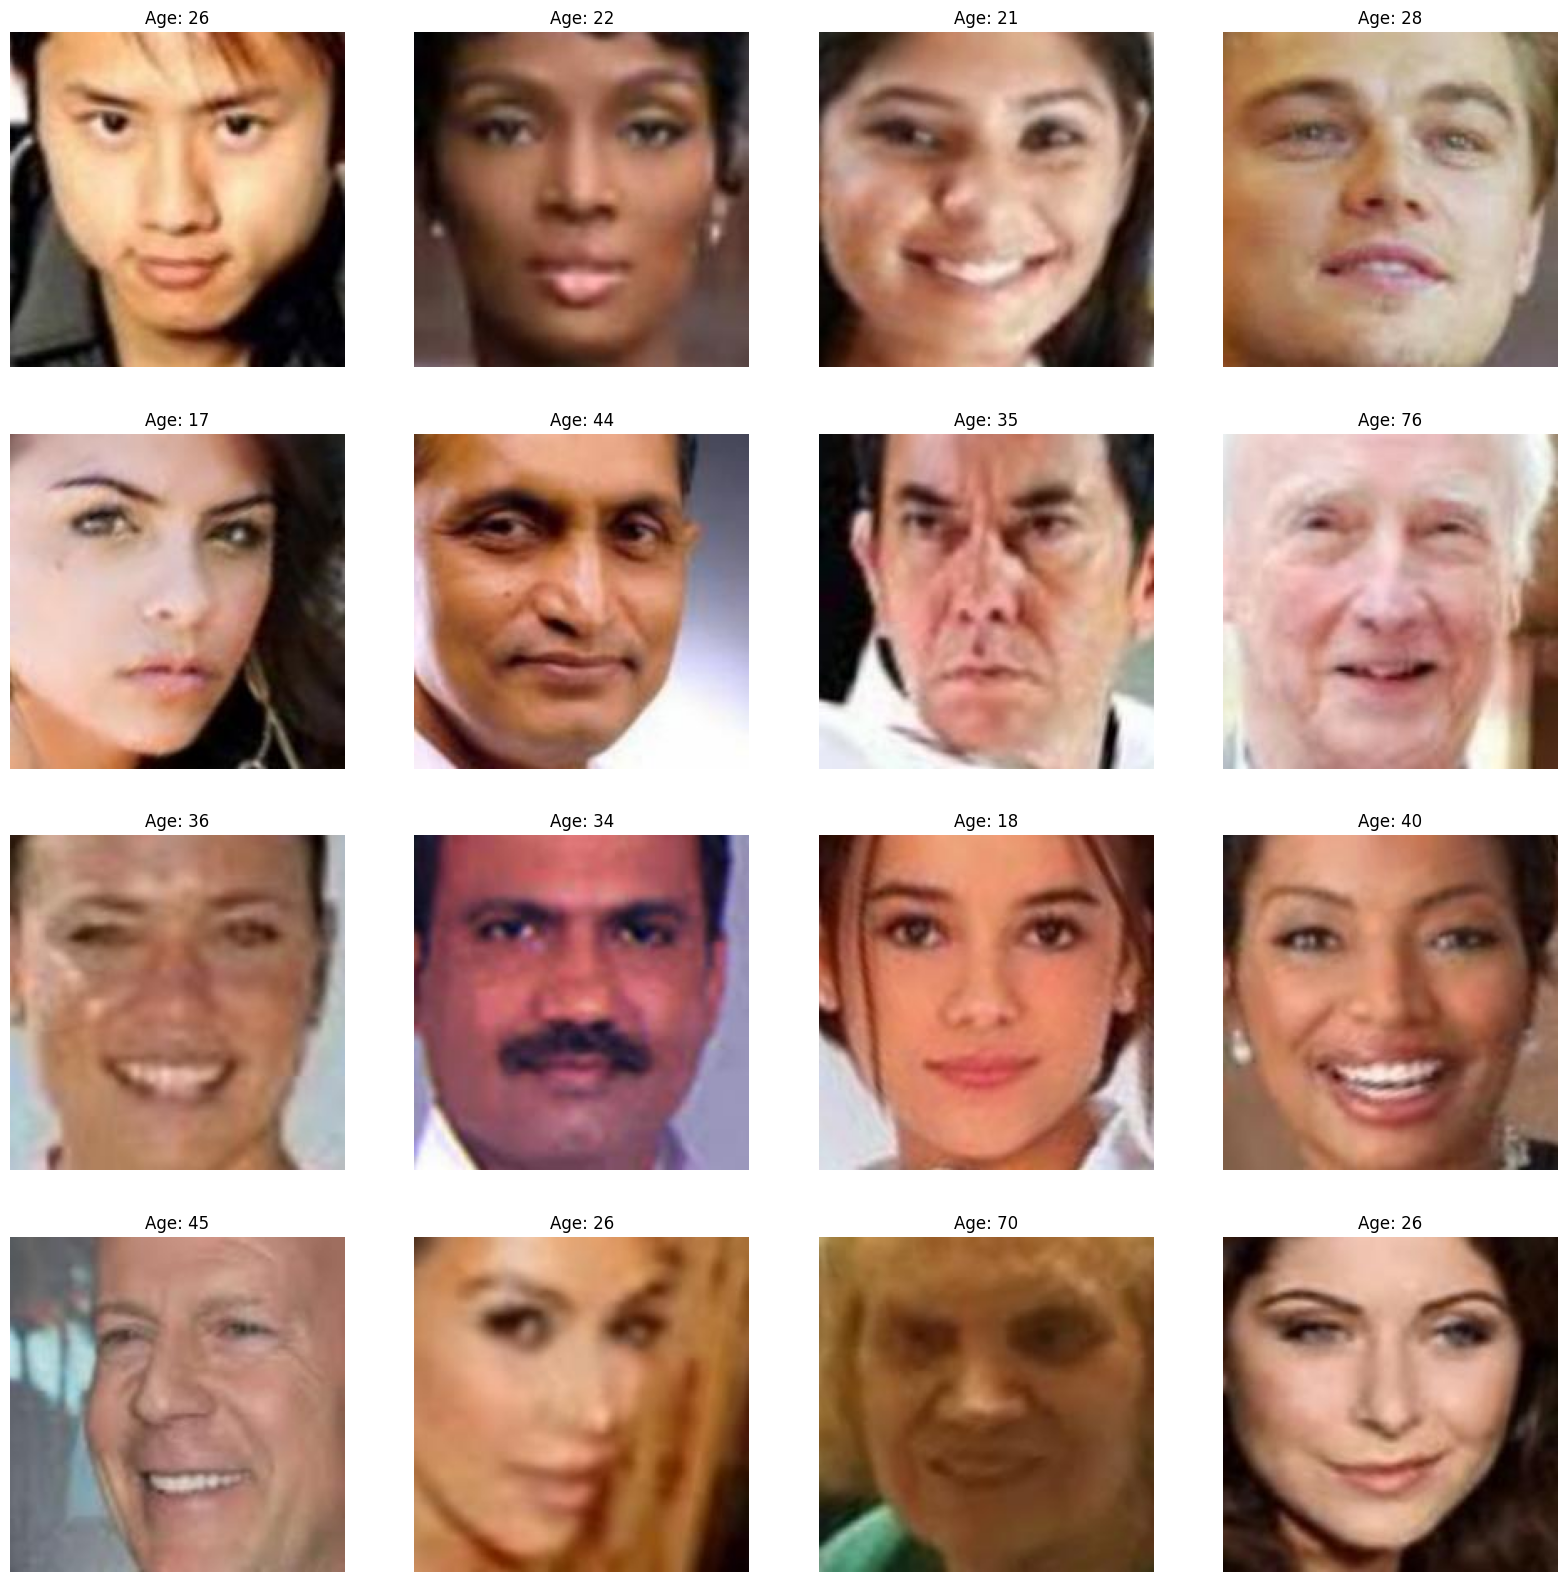

In [7]:
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = load_img(image_paths[i])
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age_labels[i]}")
    plt.axis('off')

In [8]:
def extract_features(images):
    features = []
    for image in images:
        img = load_img(image, target_size=(128, 128))
        img = img_to_array(img)
        features.append(img)
    return np.array(features)

In [9]:
X = extract_features(image_paths)
X /= 255.0

In [10]:
X_train, X_testval, y_train, y_testval = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, train_size=0.5, random_state=42)

In [11]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [12]:
# Create the regression model
def create_regression_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Regression output
    predicted_age = Dense(1, activation='linear', name='age_out')(x)

    model = Model(inputs=inputs, outputs=predicted_age)
    return model

regression_model = create_regression_model((128, 128, 3))

In [13]:
# Callbacks
model_save_path = '/kaggle/working/coral_model.keras'
regression_model.save(model_save_path)

checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [14]:
# Compile the regression model
regression_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mse', 
    metrics=['mae']
)

# Train the regression model
history_regression = regression_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 76s 116ms/step - loss: 449.6116 - mae: 16.2152 - val_loss: 239.9615 - val_mae: 11.7206 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 278.5283 - mae: 12.7320 - val_loss: 196.3085 - val_mae: 10.3766 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step - loss: 220.4477 - mae: 11.1795 - val_loss: 162.0706 - val_mae: 9.5760 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step - loss: 196.7323 - mae: 10.6265 - val_loss: 128.3835 - val_mae: 8.4186 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - loss: 169.3732 - mae: 9.7941 - val_loss: 150.5965 - val_mae: 9.7172 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - loss: 165.4496 - mae: 9.6572 - val_loss: 112.2552 - val_mae: 7.7881 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - loss: 148.2247 - mae: 9.1542 - val_loss: 113.274

In [15]:
# Load the best model
model = tf.keras.models.load_model('/kaggle/working/coral_model.keras')

In [16]:
# Evaluate the regression model
loss, mae = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Regression Mean Squared Error (MSE): {loss:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 73.9429 - mae: 6.2673
Regression Mean Squared Error (MSE): 73.821175
Regression Mean Absolute Error (MAE): 6.231882


In [17]:
# Predictions
y_pred = model.predict(X_test, verbose=1)

# Metrics Calculation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Regression Mean Squared Error (MSE): {mse:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")
print(f"Regression R² Score: {r2:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Regression Mean Squared Error (MSE): 73.8212
Regression Mean Absolute Error (MAE): 6.2319
Regression R² Score: 0.8181


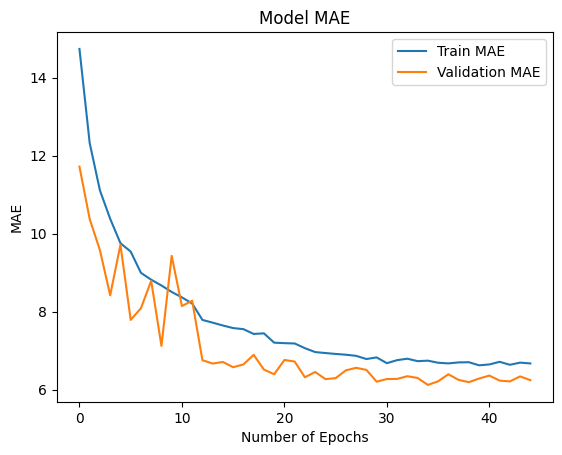

In [18]:
# Plot MAE
plt.plot(history_regression.history['mae'], label='Train MAE')
plt.plot(history_regression.history['val_mae'], label='Validation MAE')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('MAE')
plt.title('Model MAE')
plt.show()

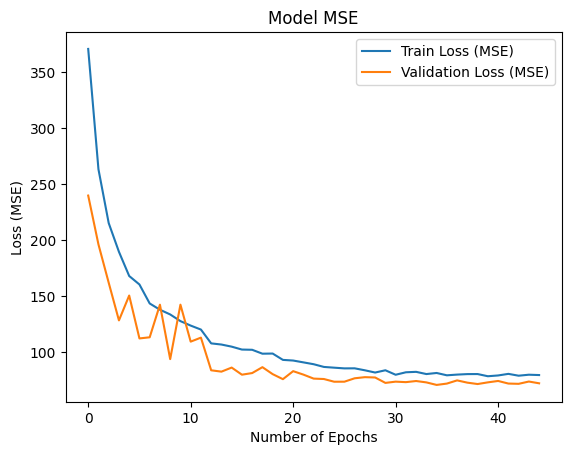

In [19]:
# Plot Loss (MSE)
plt.plot(history_regression.history['loss'], label='Train Loss (MSE)')
plt.plot(history_regression.history['val_loss'], label='Validation Loss (MSE)')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model MSE')
plt.show()